Imoprts 

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

# Hyperparameters

In [0]:
epochs = 30
nodes_per_layer = [1024,512,256,128,64]
layers = []
batch_size = 64
dropout_rate = 0.3
num_classes = 10

# Loading and Standerdizing data

Loading data

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Standerdizing the images

In [0]:
x_train = tf.map_fn(lambda image: tf.image.per_image_standardization(image), x_train, dtype=tf.float32)
x_train = tf.Session().run(x_train)
x_test = tf.map_fn(lambda image: tf.image.per_image_standardization(image), x_test, dtype=tf.float32)
x_test = tf.Session().run(x_test)


# Making and Compiling the Model

I am currently not using l2 regularization because it makes learning with generated data slower and doesn't reduce overfitting

In [0]:
layers = []
layers.append(tf.keras.layers.Flatten())
for nodes in nodes_per_layer:
 layers.append(keras.layers.Dense(nodes, activation=tf.nn.relu)) # Using l2 regularization kernel_regularizer=tf.keras.regularizers.l2(l=0.0001)
 layers.append(keras.layers.Dropout(dropout_rate))
layers.append(keras.layers.Softmax())
model = keras.Sequential(layers)

Compiling the model

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the Model

## First: without data augmentation

This training is fast and gets the model to around 50%, however it starts overfitting after that which is why we switch to training on generated data which is slower, but less likely to cause overfitting

In [0]:
overfitting_hist = model.fit(x_train, y_train,epochs=10,batch_size=64,validation_data=(x_test,y_test),use_multiprocessing=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 113us/step - loss: 0.8564 - acc: 0.7018 - val_loss: 1.1329 - val_acc: 0.6273
Epoch 2/10
50000/50000 [==============================] - 6s 114us/step - loss: 0.6771 - acc: 0.7660 - val_loss: 1.1978 - val_acc: 0.6209
Epoch 3/10
50000/50000 [==============================] - 6s 113us/step - loss: 0.5571 - acc: 0.8078 - val_loss: 1.3275 - val_acc: 0.6167
Epoch 4/10
50000/50000 [==============================] - 6s 113us/step - loss: 0.4680 - acc: 0.8382 - val_loss: 1.4718 - val_acc: 0.6200
Epoch 5/10
50000/50000 [==============================] - 6s 112us/step - loss: 0.4010 - acc: 0.8608 - val_loss: 1.5416 - val_acc: 0.6114
Epoch 6/10
50000/50000 [==============================] - 6s 112us/step - loss: 0.3503 - acc: 0.8802 - val_loss: 1.6777 - val_acc: 0.6153
Epoch 7/10
50000/50000 [==============================] - 6s 112us/step - loss: 0.3090 - acc: 0.8949 - val_loss: 1.7277 - 

Plotting training and test accuracy

Text(0,0.5,'accuracy')

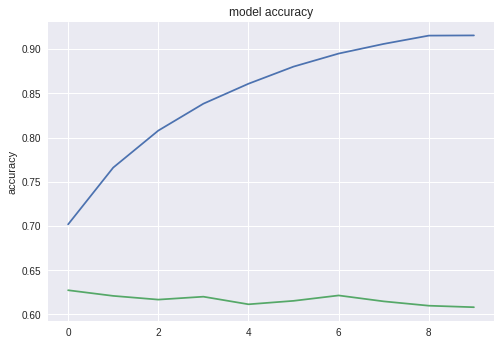

In [0]:
plt.plot(overfitting_hist.history['acc'])
plt.plot(overfitting_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')

The train accuracy is much higher than the test accuracy (by up to 35%), moreover, the test acuracy is either static or going down, which means that the model badly overfits

## Data Generation

Define data generator to generate more diverse data 


In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=7,
    zoom_range = 0.07,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range = 0.01,
    horizontal_flip=True)

Initialize variables necessary for data generation

In [0]:
datagen.fit(x_train)

## Second: using data augmentation

Training the model using the generated data to avoid overfitting
This block can be run repeatedly to get better results

In [0]:
augmented = datagen.flow(x_train, y_train, batch_size=512,shuffle=True)
hist = model.fit_generator(augmented, epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
98/98 [==============================] - 27s 275ms/step - loss: 0.9446 - acc: 0.6701 - val_loss: 1.0722 - val_acc: 0.6364
Epoch 2/10
98/98 [==============================] - 27s 273ms/step - loss: 0.9405 - acc: 0.6731 - val_loss: 1.0683 - val_acc: 0.6406
Epoch 3/10
98/98 [==============================] - 28s 282ms/step - loss: 0.9251 - acc: 0.6786 - val_loss: 1.0735 - val_acc: 0.6422
Epoch 4/10
98/98 [==============================] - 27s 274ms/step - loss: 0.9245 - acc: 0.6764 - val_loss: 1.0672 - val_acc: 0.6400
Epoch 5/10
98/98 [==============================] - 27s 273ms/step - loss: 0.9178 - acc: 0.6775 - val_loss: 1.0650 - val_acc: 0.6422
Epoch 6/10
98/98 [==============================] - 27s 277ms/step - loss: 0.9168 - acc: 0.6792 - val_loss: 1.0618 - val_acc: 0.6422
Epoch 7/10
98/98 [==============================] - 27s 276ms/step - loss: 0.9226 - acc: 0.6763 - val_loss: 1.0825 - val_acc: 0.6404
Epoch 8/10
98/98 [==============================] - 27s 278ms/step - 

Plotting accuracy curve

Text(0,0.5,'accuracy')

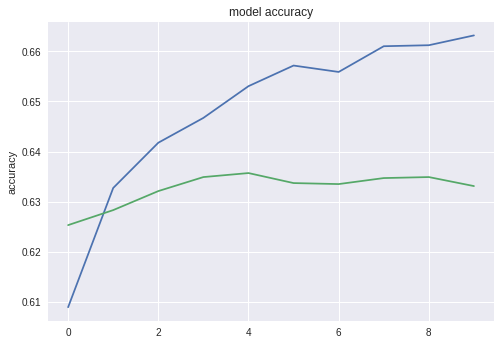

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')

In the beginning, the test accuracy is better than the training accuracy, but after the first epochs the train accuracy gets higher than the test accuracy by only up to 4% which means that the model does not worriyingly overfit

## Evaluate the Model

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 94us/step
Test accuracy: 0.6424


# Takeaway

### On the one hand
Training using the unaugmented data set wuickly results in overfitting
### On the other hand 
Using the augmented data set right away causes undefitting
### Therefore 
The best approach that I came up with is to train using unaugmented data first until that results in overfitting and then to switch to augmented data. The model has less of a hard time training on augmented data because it has already leared many of the main features of the classes before data augmentation makes learning harder but less prone to overfitting.